In [1]:
import numpy as np
import tt
import quadgauss
from eigsolvers import *
from oscillator import *
from tt.amen import amen_solve
import matplotlib.pyplot as plt
import csv
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Preparing for calculations

In [2]:
f = 12 #The number of degrees of freedom
L = 7 #The domain is [-L, L], periodic
N = 15 # The size of the spectral discretization
B = 84
eps = 1e-6

x, ws = quadgauss.cdgqf(N, 6, 0, 0.5) #Generation of hermite quadrature

omega0 = np.array([3065.0, 2297.0, 1413.0, 920.0, 3149.0, 1487.0, 1061.0, 361.0])
omega = []
for i in range(8):
    if i <= 3:
        omega.append(omega0[i])
    else:
        omega.append(omega0[i])
        omega.append(omega0[i])
omega = np.sort(np.array(omega))

# Solution of the Harmonic part of the Hamiltonian
psi_harm, E_harm, lp = tt_harmsol(omega, x, B, eps)[:3] # solution of the Harmonic part of the Hamiltonian
 
# Loading smolyak energy levels
E_table = pd.read_csv('ch3cn_data/levels.dat', header=None, delim_whitespace=True)
E_exact = np.array(E_table[8].values)
E_exact[1:] += E_exact[0]

# Loading potential and assembling Hamiltonian A
V = tt.tensor.from_list(np.load('ch3cn_data/ttpot_' + 'N' + str(N) + '_L' + str(L) + '.npy'))
A = 1./1000 * (lp + tt.diag(V)).round(eps)

## Running manifold preconditioned LOBPCG (MP LOBPCG)

In [4]:
# Assembling manifold preconditioner. kickrank=0 means ALS
shift = (E_harm[0]/1000 - 1)
MP = lambda x, E, eps, rmax: amen_solve(A - shift*tt.eye(A.n), x, x.round(0.0, rmax=rmax), 1e-6, nswp=1, kickrank=0)

In [6]:
E_lob, psi_lob, log_lob = lobpcg(A, E_harm, psi_harm, tol=1e-6, P=MP, 
                                 rmax=12, nswp=1, lam_exact=E_exact/1000, 
                                 eps=1e-6, maxiter=12)

Iteration =  1, err_eigv_best = 1.43e-02, err_eigv_worst = 1.73e-02
Iteration =  2, err_eigv_best = 1.21e-04, err_eigv_worst = 3.21e-03
Iteration =  3, err_eigv_best = 1.21e-07, err_eigv_worst = 9.57e-04
Iteration =  4, err_eigv_best = 6.18e-08, err_eigv_worst = 1.63e-04
Iteration =  5, err_eigv_best = 6.82e-08, err_eigv_worst = 5.51e-05
Iteration =  6, err_eigv_best = 1.41e-08, err_eigv_worst = 5.18e-05
Iteration =  7, err_eigv_best = 3.35e-08, err_eigv_worst = 4.69e-05
Iteration =  8, err_eigv_best = 4.21e-08, err_eigv_worst = 1.99e-05
Iteration =  9, err_eigv_best = 3.31e-09, err_eigv_worst = 3.11e-05
Iteration = 10, err_eigv_best = 1.72e-08, err_eigv_worst = 3.06e-05
Iteration = 11, err_eigv_best = 1.82e-09, err_eigv_worst = 4.29e-05
Iteration = 12, err_eigv_best = 4.57e-08, err_eigv_worst = 3.41e-05
LOBPCG did not converge with desired tolerance


In [10]:
(E_lob - E_lob[0])*1000

array([    0.        ,   361.02489752,   361.02871096,   723.24541648,
         723.25920121,   723.89339879,   900.68983825,  1034.17296272,
        1034.20845752,  1086.65713035,  1086.65811551,  1087.89661885,
        1087.91572269,  1259.90126419,  1259.93178184,  1389.71757262,
        1395.01301815,  1395.15978972,  1395.25637818,  1398.41678299,
        1451.27532786,  1451.28570182,  1453.02335795,  1453.03531537,
        1453.55189239,  1483.26873799,  1483.48560748,  1620.41543299,
        1620.42252455,  1620.93748871,  1750.68879325,  1750.74732091,
        1757.3284119 ,  1757.46671553,  1757.8753583 ,  1758.11930882,
        1760.88318765,  1760.89504822,  1785.30315058,  1817.00538602,
        1817.02479782,  1819.19155612,  1819.20001304,  1820.32978222,
        1820.36087367,  1844.89980735,  1845.18358209,  1845.5988742 ,
        1845.69811504,  1931.78480228,  1931.86240738,  1982.09352686,
        1982.29746312,  1983.14583858,  1983.23599006,  2057.3615323 ,
      

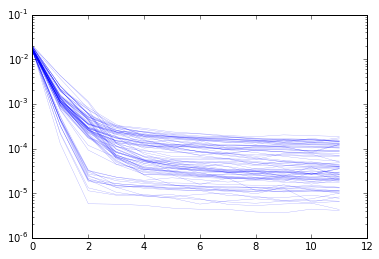

In [20]:
plt.semilogy(log_lob['err_lam_exact'], 'k-', lw=0.3, color='b', alpha=0.4);

## Running manifold preconditioned simultaneous inverse iteration (MP SII)

In [7]:
cls = cluster(E_lob, 1e-3)
cls

[[0],
 [1, 2],
 [3, 4, 5],
 [6],
 [7, 8],
 [9, 10, 11, 12],
 [13, 14],
 [15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24],
 [25, 26],
 [27, 28, 29],
 [30, 31, 32, 33, 34, 35, 36, 37],
 [38],
 [39, 40, 41, 42, 43, 44],
 [45, 46, 47, 48],
 [49, 50],
 [51, 52, 53, 54],
 [55, 56, 57],
 [58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68],
 [69, 70],
 [71, 72, 73, 74, 75, 76, 77],
 [78, 79, 80, 81, 82, 83]]

In [8]:
E_inv_25, psi_inv_25, log_inv_25 = inverse_clustered(A, E_lob, psi_lob, 1e-8, 
                                          cls=cls, eps=1e-12, rmax=25, maxiter=5, nswp=2, eps_amen=1.0,
                                          kickrank=0, verb=1, lam_exact=E_exact/1000)

Eigvals numbers: [0]
Iteration =  1, err_eigv_best = 3.77e-06, err_eigv_worst = 3.77e-06
Iteration =  2, err_eigv_best = 6.60e-08, err_eigv_worst = 6.60e-08
Iteration =  3, err_eigv_best = 3.36e-09, err_eigv_worst = 3.36e-09
 
Eigvals numbers: [1, 2]
Iteration =  1, err_eigv_best = 7.00e-06, err_eigv_worst = 7.33e-06
Iteration =  2, err_eigv_best = 7.76e-08, err_eigv_worst = 1.08e-07
Iteration =  3, err_eigv_best = 9.71e-10, err_eigv_worst = 4.25e-09
 
Eigvals numbers: [3, 4, 5]
Iteration =  1, err_eigv_best = 9.65e-06, err_eigv_worst = 1.09e-05
Iteration =  2, err_eigv_best = 8.76e-08, err_eigv_worst = 1.07e-07
Iteration =  3, err_eigv_best = 4.55e-09, err_eigv_worst = 7.96e-09
 
Eigvals numbers: [6]
Iteration =  1, err_eigv_best = 6.05e-06, err_eigv_worst = 6.05e-06
Iteration =  2, err_eigv_best = 2.98e-07, err_eigv_worst = 2.98e-07
Iteration =  3, err_eigv_best = 1.11e-08, err_eigv_worst = 1.11e-08
Iteration =  4, err_eigv_best = 1.81e-09, err_eigv_worst = 1.81e-09
 
Eigvals numbers

In [15]:
(np.array(E_inv_25)*1000 - E_exact) / (E_exact)

array([  7.17887719e-08,   2.26921335e-08,   2.84904353e-08,
         8.86744951e-09,   1.31516821e-08,   4.30401340e-08,
        -1.83111427e-07,   1.61051970e-07,   3.92983402e-07,
         2.28945258e-08,   4.74192427e-08,   9.11867332e-08,
         9.95508681e-08,  -6.39592930e-06,  -6.36430053e-06,
         3.11481131e-06,   1.13319143e-06,   1.88073228e-06,
         9.57795543e-07,   3.59320647e-06,  -4.67050748e-07,
        -4.63655731e-07,  -4.34836141e-07,  -4.26383066e-07,
        -4.36343803e-07,  -3.87824488e-07,  -2.35516365e-07,
        -1.72269637e-06,  -1.71107078e-06,  -1.73101314e-06,
         5.32206486e-06,   6.90914794e-06,   4.22782562e-06,
         4.34558766e-06,   1.48775650e-06,   1.84571434e-06,
         6.52036028e-06,   7.87999055e-06,  -8.49599096e-06,
        -7.63498718e-07,  -7.57909310e-07,  -7.29236832e-07,
        -6.25477207e-07,  -8.29870592e-07,  -8.11564733e-07,
         3.63468956e-06,  -3.88888374e-07,   4.99677711e-06,
         4.82611921e-06,

In [27]:
E_inv_40, psi_inv_40, log_inv_40 = inverse_clustered(A, E_lob, psi_inv_25, 1e-10, 
                                          cls=cls, eps=1e-12, rmax=40, maxiter=5, nswp=2, eps_amen=1.0,
                                          kickrank=0, verb=1, lam_exact=E_exact/1000)

Eigvals numbers: [0]
Iteration =  1, err_eigv_best = 3.93e-06, err_eigv_worst = 3.93e-06
Iteration =  2, err_eigv_best = 1.22e-08, err_eigv_worst = 1.22e-08
Iteration =  3, err_eigv_best = 2.94e-09, err_eigv_worst = 2.94e-09
Iteration =  4, err_eigv_best = 1.00e-09, err_eigv_worst = 1.00e-09
Iteration =  5, err_eigv_best = 2.01e-10, err_eigv_worst = 2.01e-10
AMEN inverse iteration did not converge with desired tolerance
 
Eigvals numbers: [1, 2]
Iteration =  1, err_eigv_best = 7.19e-06, err_eigv_worst = 7.56e-06
Iteration =  2, err_eigv_best = 1.33e-08, err_eigv_worst = 1.49e-08
Iteration =  3, err_eigv_best = 1.94e-09, err_eigv_worst = 2.41e-09
Iteration =  4, err_eigv_best = 9.82e-10, err_eigv_worst = 1.28e-09
Iteration =  5, err_eigv_best = 3.49e-10, err_eigv_worst = 4.03e-10
AMEN inverse iteration did not converge with desired tolerance
 
Eigvals numbers: [3, 4, 5]
Iteration =  1, err_eigv_best = 9.88e-06, err_eigv_worst = 1.12e-05
Iteration =  2, err_eigv_best = 1.73e-08, err_eigv

In [28]:
(np.array(E_inv_40)*1000 - E_exact) / (E_exact)

array([ -3.62383776e-08,  -1.08764798e-07,  -1.08332647e-07,
        -1.53510079e-07,  -1.53441036e-07,  -1.37684908e-07,
        -4.31649284e-07,  -2.13789434e-07,  -2.07441056e-07,
        -1.73388393e-07,  -1.43681212e-07,  -1.33527586e-07,
        -1.28874514e-07,  -6.71752279e-06,  -6.70903810e-06,
        -2.32684220e-07,  -6.61325020e-07,  -6.47098415e-07,
        -6.67162746e-07,  -3.15333149e-07,  -7.03603182e-07,
        -7.01550709e-07,  -7.28399472e-07,  -7.25702005e-07,
        -7.51734172e-07,  -7.85729689e-07,  -7.69693034e-07,
        -2.16765002e-06,  -2.16682501e-06,  -2.23874484e-06,
        -4.73235692e-07,  -3.27388898e-07,  -6.61286878e-07,
        -6.18047481e-07,  -8.72490003e-07,  -8.38780827e-07,
        -4.34267252e-07,  -2.41888914e-07,  -9.25066311e-06,
        -1.05022909e-06,  -1.04894401e-06,  -1.10841552e-06,
        -1.00263186e-06,  -1.22538779e-06,  -1.20931504e-06,
        -7.05896779e-07,  -7.28331475e-07,  -6.76225556e-07,
        -7.49172979e-07,